In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

print(tf.__version__)

# L2 - Training

## MNIST Classification

The MNIST dataset consists of $28\times28$ pixel images of handwritten digits and the task is to recognize the digits.
In this notebook, we use this dataset to demonstrate how to implement a few of the discussed concepts of neural network training.

In [2]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
print(f"Training images: {x_train.shape} of type: {x_train.dtype}")
print(f"Training labels: {y_train.shape} of type: {y_train.dtype}")

Training images: (60000, 28, 28) of type: uint8
Training labels: (60000,) of type: uint8


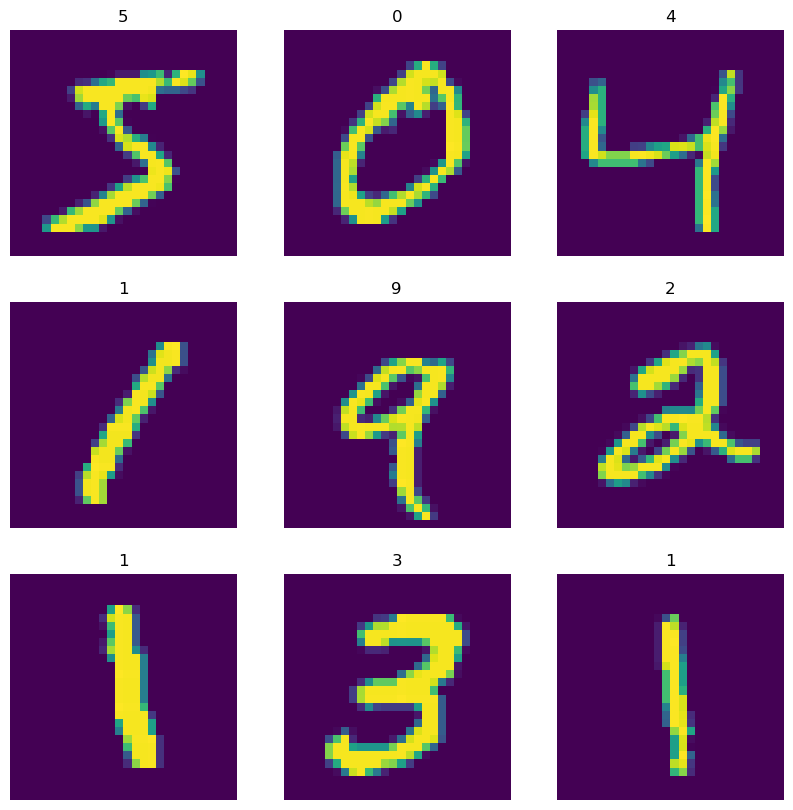

In [4]:
# visualize examples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i].astype("uint8"))
    plt.title(int(y_train[i]))
    plt.axis("off")
plt.show()

## Base Model
### Model Definition

In [5]:
def make_base_model(input_shape, classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Flatten images to 1D vectors
    x = layers.Flatten()(inputs)
    # normalize inputs
    x = layers.Rescaling(1.0 / 255)(x)
    
    # fully connected layers
    # NOTE: we could configure the dense layers directly with the required activation as in the outputs case
    x = layers.Dense(256)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(128)(x)
    x = layers.Activation("relu")(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [6]:
base_model = make_base_model(x_train.shape[1:], len(np.unique(y_train)))
base_model.summary()

: 

### Training

In [7]:
# configure training algorithm, loss function and metrics
base_model.compile(
    # use stochastic gradient descent with base learning rate
    optimizer=tf.keras.optimizers.SGD(),
    # use crossentropy loss for multiple classes
    # SparseCategoricalCrossentropy is a convenience function, which does the one-hot encoding of the labels for us
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # configure set of metrics (must be defined in tf.keras.metrics)
    metrics=['accuracy']
)

In [8]:
base_model.fit(
    # training data
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4492 - accuracy: 0.8778
Epoch 2/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.2189 - accuracy: 0.9373
Epoch 3/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1662 - accuracy: 0.9521


### Testing

In [9]:
base_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 917us/step - loss: 0.1450 - accuracy: 0.9564


[0.14495599269866943, 0.9563999772071838]

### Saving and Restoring

In [10]:
base_model_path = 'base_model.h5'

In [11]:
# save model to given path
base_model.save(base_model_path)

In [12]:
# delete model
del base_model

# restore model from saved state
base_model = tf.keras.models.load_model(base_model_path)

In [13]:
base_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 890us/step - loss: 0.1450 - accuracy: 0.9564


[0.14495599269866943, 0.9563999772071838]

## Weight Initialization

In [14]:
def make_initialization_model(input_shape, classes, kernel_initializer, bias_initializer):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Flatten images to 1D vectors
    x = layers.Flatten()(inputs)
    # normalize inputs
    x = layers.Rescaling(1.0 / 255)(x)
    
    # fully connected layers
    # NOTE: we could configure the dense layers directly with the required activation as in the outputs case
    x = layers.Dense(256, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(128, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
    x = layers.Activation("relu")(x)
    
    outputs = layers.Dense(classes, activation='softmax', 
                           kernel_initializer=kernel_initializer, 
                           bias_initializer=bias_initializer)(x)
    
    return tf.keras.Model(inputs, outputs)

### Constant Zero Initialization

In [15]:
zero_model = make_initialization_model(x_train.shape[1:], len(np.unique(y_train)),
                                       tf.keras.initializers.Zeros(), tf.keras.initializers.Zeros())

In [16]:
zero_model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
zero_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 4s 1ms/step - loss: 2.3015 - accuracy: 0.1117
Epoch 2/3
3750/3750 [==============================] - 4s 1ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 3/3
3750/3750 [==============================] - 4s 1ms/step - loss: 2.3014 - accuracy: 0.1124


### Random Initialization

In [18]:
random_model = make_initialization_model(x_train.shape[1:], len(np.unique(y_train)),
                                       tf.keras.initializers.RandomNormal(mean=0.0, stddev=1., seed=42), 
                                       # normally, biases are zero initialized by default
                                       tf.keras.initializers.Zeros())

In [19]:
random_model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [20]:
random_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 4s 1ms/step - loss: 9.8584 - accuracy: 0.6856
Epoch 2/3
3750/3750 [==============================] - 4s 1ms/step - loss: 1.0715 - accuracy: 0.7317
Epoch 3/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.8351 - accuracy: 0.7867


### He Initialization

We have seen Xavier initalization already in the base example, since this is the default initialization scheme for a dense
layer.

In [21]:
he_model = make_initialization_model(x_train.shape[1:], len(np.unique(y_train)),
                                       tf.keras.initializers.HeNormal(), 
                                       tf.keras.initializers.Zeros())

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [22]:
he_model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [23]:
he_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.4184 - accuracy: 0.8853
Epoch 2/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.2113 - accuracy: 0.9396
Epoch 3/3
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1606 - accuracy: 0.9534


$\Rightarrow$ There does not seem to be much difference between Xavier and He initialization in this case.
This is not unexpected, since problems with Xavier initialization should become apparent only for deeper networks.

## Training Algorithms

### Adam

In [24]:
adam_model = make_base_model(x_train.shape[1:], len(np.unique(y_train)))

In [25]:
adam_model.compile(
    # simply change the optimizer to one implemented in tf.keras.optimizers
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
adam_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1910 - accuracy: 0.9421
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0861 - accuracy: 0.9737
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0627 - accuracy: 0.9803


In [27]:
adam_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 891us/step - loss: 0.0792 - accuracy: 0.9764


[0.07922563701868057, 0.9764000177383423]

## Regularization
### Weight Decay

In [28]:
def make_regularization_model(input_shape, classes, kernel_regularizer):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Flatten images to 1D vectors
    x = layers.Flatten()(inputs)
    # normalize inputs
    x = layers.Rescaling(1.0 / 255)(x)
    
    # fully connected layers
    x = layers.Dense(256, kernel_regularizer=kernel_regularizer)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(128, kernel_regularizer=kernel_regularizer)(x)
    x = layers.Activation("relu")(x)
    
    outputs = layers.Dense(classes, activation='softmax', 
                           kernel_regularizer=kernel_regularizer)(x)
    
    return tf.keras.Model(inputs, outputs)

In [29]:
weight_decay_model = make_regularization_model(x_train.shape[1:], len(np.unique(y_train)),
                                               tf.keras.regularizers.L2())

In [30]:
weight_decay_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
weight_decay_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 6s 2ms/step - loss: 1.0053 - accuracy: 0.8826
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.8135 - accuracy: 0.9002
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.7957 - accuracy: 0.9037


$\Rightarrow$ Obvsiously, we overdid the regularization here - this requires tuning.

### Early Stopping

In [32]:
early_stopping_model = make_base_model(x_train.shape[1:], len(np.unique(y_train)))

In [33]:
early_stopping_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [34]:
# define callbacks
my_callbacks = [
    # configure early stopping -> by default, stop if validation loss did not improve for three epochs
    tf.keras.callbacks.EarlyStopping(patience=3),
    # reduce learning rate if training stalled - NOTE: you probably want to set the patience levels higher for both
    # early stopping and this learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    # log training progress for TensorBoard
    tf.keras.callbacks.TensorBoard('log_dir'),
    # log training progress as CSV file
    # tf.keras.callbacks.CSVLogger('training.log')
    # save currently best performing model based on validation loss
    # tf.keras.callbacks.ModelCheckpoint(filepath='best.h5', save_best_only=True)
]

In [35]:
early_stopping_model.fit(
    x=x_train, y=y_train,
    # configure validation split
    validation_split=0.2,
    batch_size=16,
    epochs=20,
    # set callbacks
    callbacks=my_callbacks
)

Epoch 1/20
3000/3000 [==============================] - 5s 1ms/step - loss: 0.2167 - accuracy: 0.9346 - val_loss: 0.1400 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 2/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0927 - accuracy: 0.9707 - val_loss: 0.0964 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 3/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0656 - accuracy: 0.9791 - val_loss: 0.1099 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 4/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0475 - accuracy: 0.9849 - val_loss: 0.0981 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 5/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0735 - val_accuracy: 0.9812 - lr: 1.0000e-04
Epoch 6/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0759 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 7/20
3000/3000 [============================

In [36]:
early_stopping_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 940us/step - loss: 0.0647 - accuracy: 0.9838


[0.06472136080265045, 0.9837999939918518]

$\Rightarrow$ so far the best, but we also trained longer…

### Dropout

In [37]:
def make_dropout_model(input_shape, classes, dropout_config):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Flatten images to 1D vectors
    x = layers.Flatten()(inputs)
    # normalize inputs
    x = layers.Rescaling(1.0 / 255)(x)
    
    # fully connected layers
    x = layers.Dense(256)(x)
    x = layers.Activation("relu")(x)
    if dropout_config[0] is not None:
        x = layers.Dropout(dropout_config[0])(x)
    x = layers.Dense(128)(x)
    x = layers.Activation("relu")(x)
    if dropout_config[1] is not None:
        x = layers.Dropout(dropout_config[1])(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [38]:
heavy_dropout_model = make_dropout_model(x_train.shape[1:], len(np.unique(y_train)), [0.5, 0.5])

In [39]:
heavy_dropout_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [40]:
heavy_dropout_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 6s 1ms/step - loss: 0.4051 - accuracy: 0.8778
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2304 - accuracy: 0.9328
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1981 - accuracy: 0.9433


In [41]:
light_dropout_model = make_dropout_model(x_train.shape[1:], len(np.unique(y_train)), [None, 0.2])

In [42]:
light_dropout_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [43]:
light_dropout_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.2118 - accuracy: 0.9359
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0966 - accuracy: 0.9702
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0690 - accuracy: 0.9785


In [44]:
light_dropout_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 911us/step - loss: 0.0799 - accuracy: 0.9778


[0.07994246482849121, 0.9778000116348267]

$\Rightarrow$ possibly some advantage of the model with light dropout compared to the base model

### Batch Normalization

In [45]:
def make_batchnorm_model(input_shape, classes, batchnorm_config):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Flatten images to 1D vectors
    x = layers.Flatten()(inputs)
    # normalize inputs
    x = layers.Rescaling(1.0 / 255)(x)
    
    # fully connected layers
    x = layers.Dense(256)(x)
    if batchnorm_config[0] is True:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(128)(x)
    if batchnorm_config[1] is True:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    outputs = layers.Dense(classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

In [46]:
batchnorm_model = make_batchnorm_model(x_train.shape[1:], len(np.unique(y_train)), [True, True])

In [47]:
batchnorm_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [48]:
batchnorm_model.fit(
    x=x_train, y=y_train,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 6s 2ms/step - loss: 0.2422 - accuracy: 0.9265
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1272 - accuracy: 0.9605
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1027 - accuracy: 0.9673


$\Rightarrow$ does not seem to do that much here, but this is a rather shallow network and we train for few epochs

### Data Augmentation

In [49]:
# convert numpy arrays to TensorFlow dataset for augmentation
train_ds = tf.data.Dataset.from_tensor_slices((x_train.reshape((-1, 28, 28, 1)), y_train))

In [50]:
# define augmentations to apply
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomRotation(0.1),
        # move image by 20% up/down/left/right - determine pixels to fill in by boarder pixels
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest')
    ]
)

In [51]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# shuffle and batch dataset
train_ds = train_ds.shuffle(100).batch(16)

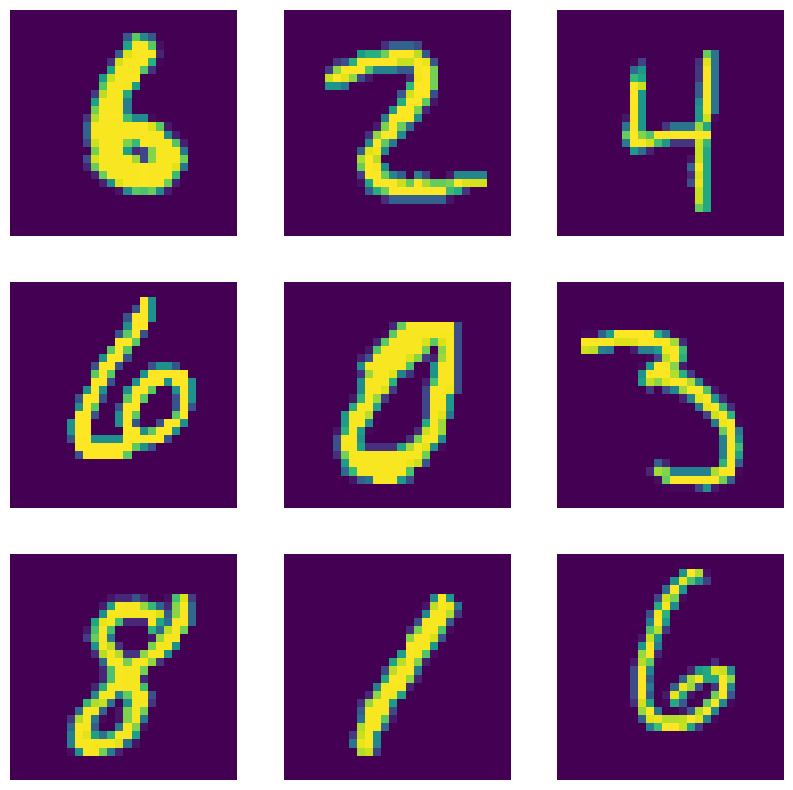

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [53]:
augment_model = make_base_model(x_train.shape[1:], len(np.unique(y_train)))

In [54]:
augment_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [55]:
augment_model.fit(
    train_ds,
    batch_size=16,
    epochs=3,
)

Epoch 1/3
3750/3750 [==============================] - 6s 1ms/step - loss: 0.1918 - accuracy: 0.9429
Epoch 2/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0866 - accuracy: 0.9737
Epoch 3/3
3750/3750 [==============================] - 5s 1ms/step - loss: 0.0601 - accuracy: 0.9816


In [56]:
augment_model.evaluate(
    x=x_test, y=y_test
)

313/313 [==============================] - 0s 905us/step - loss: 0.0973 - accuracy: 0.9733


[0.09725691378116608, 0.9732999801635742]

$\Rightarrow$ as in many of these cases, we would need to train for longer to benefit from the change